## Chapter-2: Building a Neural Network from Scratch

#### Imports

In [145]:
import math
import random
import numpy as np
from graphviz import Digraph
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

### Backbone Unit class
- Weights and Biases
- Automatic Differentiation and Gradient Tracking

In [100]:
class Unit:
    def __init__(self, data, parents=[], op=""):
        self.data, self.parents, self.op = data, parents, op
        self.grad = 0.0
        self._backprop = lambda: None
        
    def __repr__(self):
        return f"{self.data, self.grad}"

    def relu(self):
        out = Unit(max(0, self.data), parents=(self,), op='relu')

        def _backprop():
            self.grad += out.grad * (out.data > 0)
    
        out._backprop = _backprop
        return out
    
    def __add__(self, other):
        other = other if isinstance(other, Unit) else Unit(other)
        out = Unit(self.data + other.data, parents=[self, other], op="+")
        def _backprop():
            self.grad += out.grad
            other.grad += out.grad

        out._backprop = _backprop
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Unit) else Unit(other)
        out = Unit(self.data * other.data, parents=[self, other], op="*")

        def _backprop():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backprop = _backprop
        return out

    def __pow__(self, other):
        out = Unit(self.data**other, parents=[self], op=f"^{other}")

        def _backprop():
            # derivative of xn is nxn-1
            self.grad += out.grad * (other * self.data**(other-1))

        out._backprop = _backprop
        return out

    def log(self):
        out = Unit(math.log(self.data), parents=[self], op="log")

        def _backprop():
            # Gradient is Gradient from Previous step a.k.a out.grad
            # multiplied with gradient of log which is 1 / self.data
            self.grad += out.grad * (1 / self.data)

        out._backprop = _backprop 
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other) # same as self - other

    def __rsub__(self, other):
        return other + (-self)

    def __neg__(self):
        return Unit(-self.data, parents=self.parents, op=self.op)

    def __rmul__(self, other):
        return self * other

    # Division Operator
    def __truediv__(self, other):
        return self * (other**-1) # a / b is same as a * b-1

    def topological_sort(self):
        visited = set()
        sorted_nodes = []

        def build(node):
            if node not in visited:
                visited.add(node)
            for parent in node.parents:
                if isinstance(parent, Unit):
                    build(parent)
            sorted_nodes.append(node)

        build(self)
        # returning the nodes in reverse order
        # as we want to compute gradients from bottom up
        return reversed(sorted_nodes)

    def backpropagation(self):
        # Find the order in which back propagation should be called
        sorted_nodes = self.topological_sort()
        # Call back propagation methods
        for node in sorted_nodes:
            node._backprop()


### A simple System of Equations to Illustrate how Unit class works

In [102]:
x = Unit(2.0)
y = Unit(3.0)
z = x + y
w = z * x
l = w ** 2
n = l.relu()

In [103]:
n.grad = 1.0

In [104]:
n.backpropagation()

### Methods for Visualizing the Graph Execution Engine

In [105]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            if isinstance(v, (int, float)):
              return
            for child in v.parents:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='png', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        if isinstance(n, (int, float)):
            continue
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f}" % (n.data, n.grad), shape='record')
        if n.op:
            dot.node(name=str(id(n)) + n.op, label=n.op)
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    return dot

### Output Graph

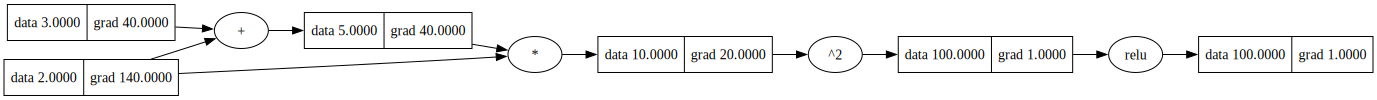

In [106]:
draw_dot(n)

### Neuron Class
- Built on top of Unit class
- Contains weights and biases of a neuron

In [107]:
class Neuron:
    def __init__(self, num_inputs, activation=""):
        self.weights = [Unit(random.uniform(-1,1)) for _ in range(num_inputs)]
        self.bias = Unit(random.uniform(-1,1))
        self.activation = activation

    def __call__(self, inputs):
        out = sum(wi*xi for wi, xi in zip(self.weights, inputs))
        out += self.bias
        if self.activation == "relu":
            out = out.relu()
        return out

    def parameters(self):
        return self.weights + [self.bias]

### Layer Class
- Built on top of Neuron Class
- Constructs a layer of neurons

In [108]:
class Layer:
	def __init__(self, n_in, n_out, activation=""):
		self.neurons = [Neuron(n_in, activation) for _ in range(n_out)]

	def __call__(self, input_vec):
		out = [n(input_vec) for n in self.neurons]
		return out[0] if len(out) == 1 else out

	def parameters(self):
		return [p for n in self.neurons for p in n.parameters()]

### MLP Class
- Built on top of Layer class
- Defines a MLP model of any shape and size

In [136]:
class MLP:
	def __init__(self, shapes):
		# Initializing layers in MLP
		self.layers = [Layer(shapes[i-1], shapes[i], "relu") for i in range(1, len(shapes)-1)]
		# All the layers except the last layer have ReLU activation
		self.layers.append(Layer(shapes[-2], shapes[-1]))

	def __call__(self, input_vec):
		for layer in self.layers:
			input_vec = layer(input_vec)
		return input_vec

	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

### Defining a simple MLP model
- 2 Hidden Layers with 16 Neurons in each layer
- 2 Dimensional Input
- 1 Scalar output which is positive for positive class & negative for negative class

In [137]:
mlp = MLP([2, 16, 16, 1])

### Generating a Toy Dataset for Classification

Text(0.5, 1.0, '2D Toy Dataset')

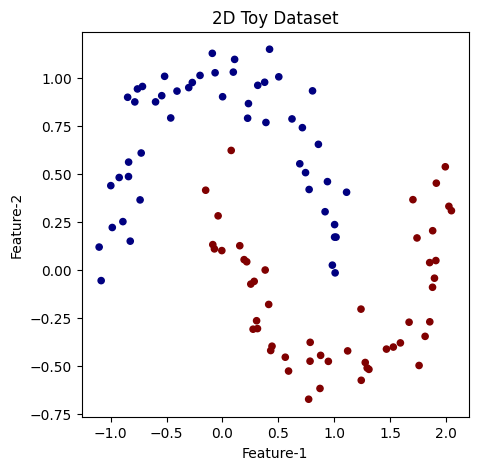

In [138]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.xlabel("Feature-1");plt.ylabel("Feature-2")
plt.title("2D Toy Dataset")

### Setting up a Training Loop

In [139]:

def trainer(model, X, y, epochs=10, learning_rate=0.005):
    losses_per_epoch, accuracy_per_epoch = [], []
    for epoch in range(epochs):
        # Step-1: Run the Model and save results
        predictions, loss = [], []
        for xi, yi in zip(X, y):
            out = model(xi)
            predictions.append(1 if out.data > 0 else -1)
            loss.append((1 + -yi*out).relu())

        # Step-2: Compute Total Loss
        total_loss = sum(loss) / len(loss) # Average Loss

        # Step-3: Compute Gradients with respect to Loss
        total_loss.grad = 1
        total_loss.backpropagation()

        # Step-4: Update Weights based on Gradients
        for weight in model.parameters():
            weight.data -= weight.grad * learning_rate

        # Step-5: Reset the Gradients
        for weight in model.parameters():
            weight.grad = 0.0

        # Logging
        accuracy = accuracy_score(predictions, y)
        losses_per_epoch.append(total_loss.data)
        accuracy_per_epoch.append(accuracy)
        print(f"Epoch:{epoch}, Loss: {total_loss.data}, Accuracy: {accuracy}")

    return losses_per_epoch, accuracy_per_epoch


In [140]:
losses, accuracy_scores = trainer(mlp, X, y)

Epoch:0, Loss: 1.0289653269370203, Accuracy: 0.53
Epoch:1, Loss: 2.2536551540622853, Accuracy: 0.74
Epoch:2, Loss: 1.7456490761600456, Accuracy: 0.76
Epoch:3, Loss: 1.30509803812655, Accuracy: 0.77
Epoch:4, Loss: 0.9520466858096931, Accuracy: 0.79
Epoch:5, Loss: 0.7538200140474804, Accuracy: 0.79
Epoch:6, Loss: 0.6541367374698398, Accuracy: 0.78
Epoch:7, Loss: 0.7010438512424466, Accuracy: 0.79
Epoch:8, Loss: 0.6852541897297286, Accuracy: 0.79
Epoch:9, Loss: 0.6575923228765, Accuracy: 0.82


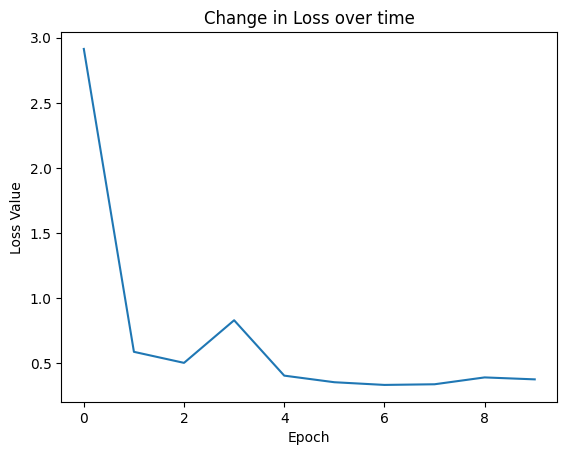

In [141]:
plt.title("Change in Loss over time")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(range(len(loss)), loss)

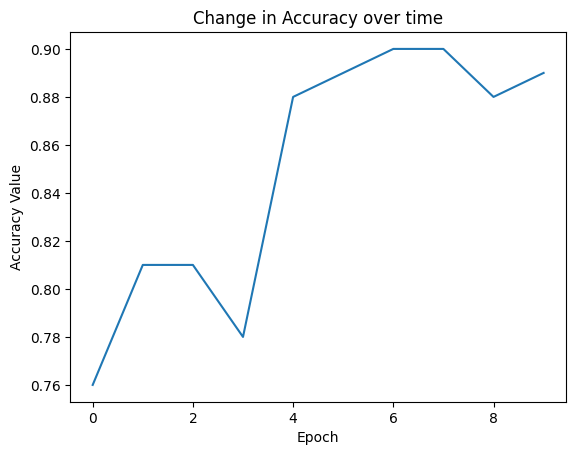

In [142]:
plt.title("Change in Accuracy over time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Value")
plt.plot(range(len(accuracy)), accuracy)

### Visualizing the decision boundary

Text(0, 0.5, 'Feature-2')

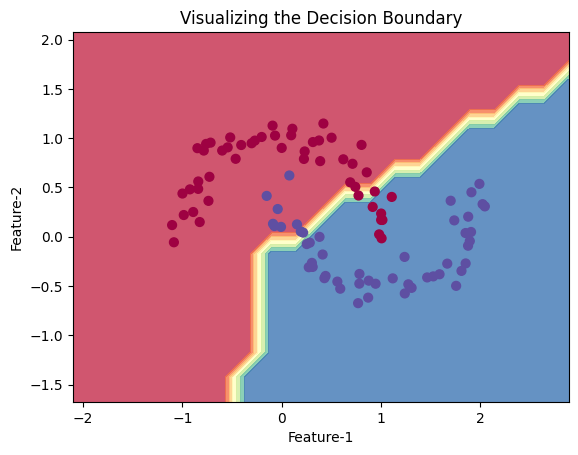

In [147]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Unit, xrow)) for xrow in Xmesh]
scores = list(map(mlp, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Visualizing the Decision Boundary")
plt.xlabel("Feature-1")
plt.ylabel("Feature-2")